# Data Source
* [Food Production](https://www.fao.org/faostat/en/#data/QCL)

# Data Preparation

In [34]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [35]:
food_prod = pd.read_csv("data" + os.sep + "food production" + os.sep + "Production_Crops_Livestock_E_All_Data_NOFLAG.csv", sep=",", encoding="latin-1")
food_prod.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,19500.0,18500.0,18500.0,30000.0,25000.0,24500.0,26500.0,25333.0,25444.0,25759.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6414.0,6757.0,6757.0,7167.0,7200.0,7075.0,7149.0,7142.0,7123.0,7138.0


In [36]:
# only use production amounts
food_prod = food_prod[food_prod["Element"] == "Production"]
food_prod.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,12508.0,12500.0,12500.0,21500.0,18000.0,17333.0,18944.0,18093.0,18123.0,18387.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0
15,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0


In [37]:
# only use the production data iself
food_prod = food_prod.iloc[:,7:]
food_prod.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12508.0,12500.0,12500.0,21500.0,18000.0,17333.0,18944.0,18093.0,18123.0,18387.0
8,15100.0,15100.0,15100.0,18400.0,20400.0,22800.0,27600.0,27900.0,28200.0,27300.0,...,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0
11,32000.0,32000.0,32000.0,39200.0,43400.0,48400.0,58700.0,59400.0,60000.0,58100.0,...,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0
15,378000.0,378000.0,378000.0,380000.0,380000.0,375000.0,357000.0,361000.0,365000.0,370000.0,...,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0


In [38]:
# Calculate total sums for the years
food_prod = food_prod.sum(axis=0)
food_prod = pd.Series(food_prod)
food_prod.tail()

Y2016    1.090368e+11
Y2017    1.120533e+11
Y2018    1.130403e+11
Y2019    1.146314e+11
Y2020    1.103574e+11
dtype: float64

Text(0.5, 0, 'Year')

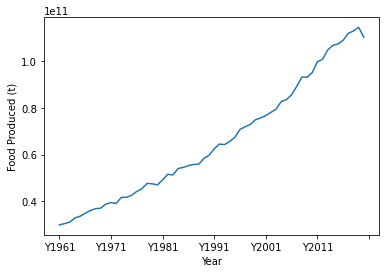

In [39]:
# Plot it
ax= food_prod.plot()
ax.set_ylabel("Food Produced (t)")
ax.set_xlabel("Year")
# Is the drop in 2020 real?